## Optimized texture calculation

Notebook showing optimization of texture calculation using matrix convolutions

In [44]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
from copy import deepcopy
import math
from scipy import ndimage, signal

In [45]:
radar_mcs_path = '/home/rjackson/data/radar/cpol/Gunn_pt_20060305121000ppi.nc'
radar_mcs = pyart.io.read(radar_mcs_path)

# Texture calculation via convolution

In the old methodology, the texture was calculated by using scipy's generic_filter and applying the angular standard deviation over a window.


The new methodology uses convolutions. The convolution operation of a matrix Y with its kernel X is.

$\begin{bmatrix}
    x_{11}       & x_{12} & x_{13} & \dots & x_{1n} \\
    x_{21}       & x_{22} & x_{23} & \dots & x_{2n} \\
    x_{m1}       & x_{m2} & x_{m3} & \dots & x_{mn}
\end{bmatrix} * \begin{bmatrix}
    y_{11}       & y_{12} & y_{13} & \dots & y_{1n} \\
    y_{21}       & y_{22} & y_{23} & \dots & y_{2n} \\
    y_{m1}       & y_{m2} & y_{m3} & \dots & y_{mn}
\end{bmatrix} [x_{ij}, y_{ij}] = \sum_{i=1}^{m} \sum_{j=1}^{n} x_{ij}y_{(m-i+1)(n-j+1)} $

To take the mean of a 3x3 window, we just convolve X = 3x3 matrix of ones with Y = 3x3 velocity window.

Therfore, to get the angular standard deviation, we first map the velocities into a phase space where -pi = -Nyquist and pi = Nyquist (from Py-ART code). The standard deviation is calculated from the norm of the window which is:

$N = (\bar{C}^{2} + \bar{S}^{2})^{1/2}$

Where C is the matrix containing the cosine of each entry in Y and S is the matrix containing the sine of each entry in Y.

To get the mean of C, we convolve C with X and divide that result by the convolution of X with itself. This is equivalent to adding each entry in C and dividing by the total number of entries.

Scipy's signal processing package has a routine convolve2d to do this very quickly.

Based off of std devation code in Py-ART.

In [49]:
# Use convolutions to calculate angular texture
def std_convoluted_radar(image, N, interval):
    # transform distribution from original interval to [-pi, pi]
    interval_max = interval[1]
    interval_min = interval[0]
    half_width = (interval_max - interval_min) / 2.
    center = interval_min + half_width
    
    # Calculate parameters needed for angular std. dev
    a = (np.asarray(image) - center) / (half_width) * np.pi
    im = a
    x = np.cos(im)
    y = np.sin(im)

    ones = np.ones(x.shape)
    
    # Calculate convolution
    kernel = np.ones((N, N))
    xs = signal.convolve2d(x, kernel, mode="same")
    ys = signal.convolve2d(y, kernel, mode="same")
    ns = signal.convolve2d(ones, kernel, mode="same")
    
    # Calculate norm over specified window
    xmean = xs/ns
    ymean = ys/ns
    norm = np.sqrt(xmean**2 + ymean**2)
    std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
    return ndimage.filters.median_filter(std_dev, size=(N, N))

In [50]:
gatefilter = pyart.filters.GateFilter(radar_mcs)

nyq_Gunn = radar_mcs.instrument_parameters['nyquist_velocity']['data'][0]
bt = time.time()
data = ndimage.filters.generic_filter(radar_mcs.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (4,4),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data_old = ndimage.filters.median_filter(data, size = (4,4))
texture_field_old = pyart.config.get_metadata('velocity')
texture_field_old['data'] = filtered_data_old
radar_mcs.add_field('velocity_texture_old', 
                    texture_field_old, 
                    replace_existing = True)  
old_time = time.time()-bt
print('Time for old method:' + str(old_time))

bt = time.time()
filtered_data = std_convoluted_radar(radar_mcs.fields['velocity']['data'], 
                                     4, 
                                     (-nyq_Gunn, nyq_Gunn))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
texture = texture_field['data']

radar_mcs.add_field('velocity_texture', 
                    texture_field, 
                    replace_existing = True) 
new_time = time.time()-bt
print('Time for new method:' + str(new_time))
print('The new method is ' + str(old_time/new_time) + ' times faster')

Time for old method:37.6479210854


/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in sqrt


Time for new method:0.742634057999
The new method is 50.6951178442 times faster


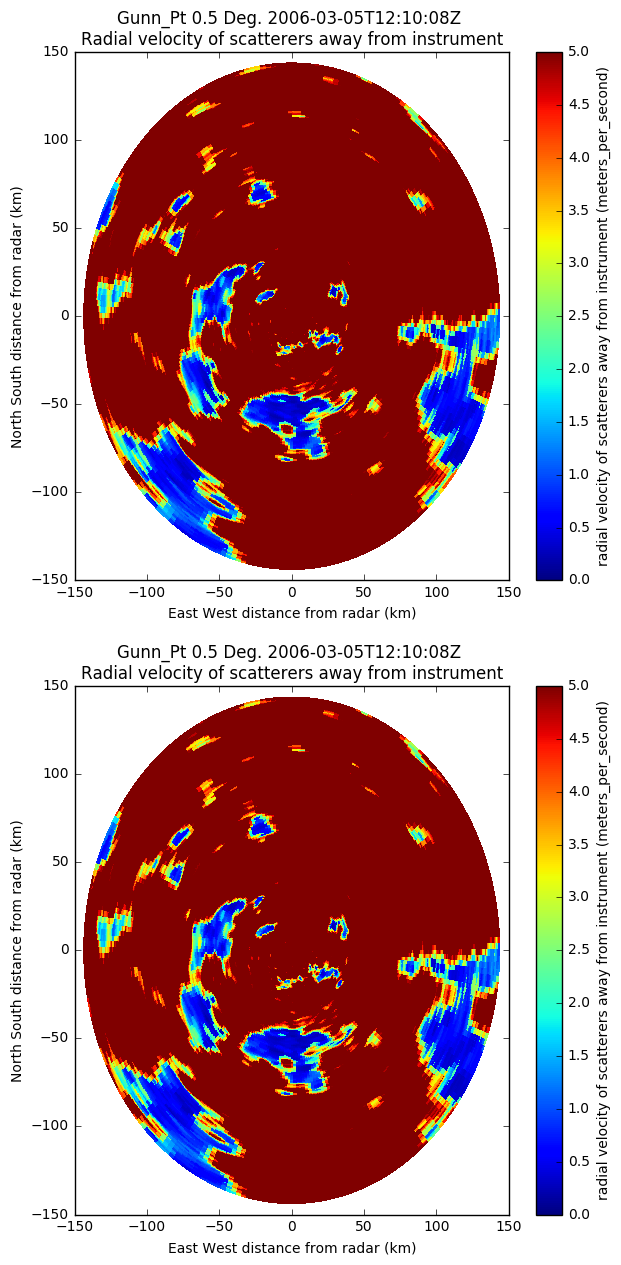

In [51]:
#gatefilter.exclude_below('cross_correlation_ratio', 0.5)
#gatefilter.exclude_below('reflectivity',0)
display_mcs = pyart.graph.RadarMapDisplay(radar_mcs)
plt.figure(figsize=(7,15))
plt.subplot(211)
display_mcs.plot_ppi('velocity_texture_old',  gatefilter=gatefilter, vmin=0, vmax=5)
plt.subplot(212)
display_mcs.plot_ppi('velocity_texture',  gatefilter=gatefilter, vmin=0, vmax=5)